Selected Facilities Analysis - Final Configuration
# Phoenix, Dallas, and Columbus Network Configuration
This notebook analyzes the three selected facilities based on the demand clusters:
1. Phoenix, AZ (Western Region) - FAC027 (52,000 sqft)
2. Dallas, TX (Central Region) - FAC047 (40,000 sqft)
3. Columbus, OH (Eastern Region) - FAC035 (58,000 sqft)

Key advantages of this configuration:
- Columbus: Large facility (58,000 sqft) with moderate costs ($12.6/sqft)
- Dallas: Strategic central location with moderate costs ($12.4/sqft)
- Phoenix: Good size (52,000 sqft) serving western markets with moderate costs ($12.9/sqft)

# Import Required Libraries

In [49]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline

# Load and Prepare Data

In [50]:
# Load all datasets
demand_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data/demand.csv')
products_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data/products.csv') # pd.read_csv('Assignment Files/Data/products.csv')
stores_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//stores.csv')
rates_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//rates.csv')
labor_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//labor_cost.csv')
facilities_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//facilities.csv')

# Calculate annual demand in pallets
demand_df = demand_df.merge(products_df[['SKU', 'SKUs/pallet']], on='SKU', how='left')
demand_df['Demand_Pallets'] = demand_df['Demand'] / demand_df['SKUs/pallet']
annual_demand = demand_df.groupby('StoreID')['Demand_Pallets'].sum().reset_index()
store_demand = stores_df.merge(annual_demand, on='StoreID', how='left')

# Cluster Analysis

In [51]:
# Prepare data for clustering
X = store_demand[['Latitude', 'Longitude']].values
weights = store_demand['Demand_Pallets'].values

# Perform 3-cluster analysis
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X, sample_weight=weights)
store_demand['Cluster'] = kmeans.labels_

# Selected facilities
selected_facilities = {
    'Western': facilities_df[facilities_df['FacilityID'] == 'FAC027'].iloc[0],  # Phoenix
    'Central': facilities_df[facilities_df['FacilityID'] == 'FAC047'].iloc[0],  # Dallas
    'Eastern': facilities_df[facilities_df['FacilityID'] == 'FAC035'].iloc[0]   # Columbus
}

# Calculate total facility costs
facility_costs = pd.DataFrame([
    {
        'Region': region,
        'Location': facility['Location'],
        'Size': facility['Size_SqFt'],
        'Total_Cost': facility['RentCost_SqFt'] + facility['UtilitiesOpsCost_SqFt']
    }
    for region, facility in selected_facilities.items()
])

print("\nFacility Cost Summary:")
display(facility_costs)


Facility Cost Summary:


c:\Users\k_pow\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Region,Location,Size,Total_Cost
0,Western,"Phoenix, AZ",52000,12.9
1,Central,"Dallas, TX",40000,12.4
2,Eastern,"Columbus, OH",58000,12.6


# Create Network Map with Clusters

In [52]:
# Get facility coordinates from stores data
def get_facility_coordinates(facility_location, stores_df):
    city = facility_location.split(',')[0].strip()
    state = facility_location.split(',')[1].strip()
    matching_store = stores_df[
        (stores_df['City'] == city) & 
        (stores_df['State'] == state)
    ].iloc[0]
    return matching_store['Latitude'], matching_store['Longitude']

# Create dictionary of facility coordinates
facility_coordinates = {}
for region, facility in selected_facilities.items():
    lat, lon = get_facility_coordinates(facility['Location'], stores_df)
    facility_coordinates[facility['Location']] = {'Latitude': lat, 'Longitude': lon}

def create_network_map():
    """Create a map showing selected facilities and their clusters"""
    m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
    
    # Define colors for each region
    region_colors = {
        'Western': '#FF6B6B',  # Red
        'Central': '#4D96FF',  # Blue
        'Eastern': '#6BCB77'   # Green
    }
    
    # Add stores with cluster colors
    for idx, store in store_demand.iterrows():
        folium.CircleMarker(
            location=[store['Latitude'], store['Longitude']],
            radius=4,
            color=list(region_colors.values())[store['Cluster']],
            fill=True,
            popup=f"Store: {store['StoreID']}<br>" +
                  f"City: {store['City']}, {store['State']}<br>" +
                  f"Annual Demand: {store['Demand_Pallets']:,.0f} pallets"
        ).add_to(m)
    
    # Add facilities with custom icons and labels
    for region, facility in selected_facilities.items():
        # Get facility coordinates
        coords = facility_coordinates[facility['Location']]
        
        # Create a custom icon for facilities
        facility_icon = folium.DivIcon(
            html=f'''
                <div style="
                    width: 20px;
                    height: 20px;
                    border-radius: 50%;
                    background-color: {region_colors[region]};
                    border: 3px solid black;
                    display: flex;
                    align-items: center;
                    justify-content: center;
                "></div>
            '''
        )
        
        # Add facility marker
        folium.Marker(
            location=[coords['Latitude'], coords['Longitude']],
            icon=facility_icon,
            popup=f"Facility: {facility['Location']}<br>" +
                  f"Size: {facility['Size_SqFt']:,} sqft<br>" +
                  f"Total Cost: ${facility['RentCost_SqFt'] + facility['UtilitiesOpsCost_SqFt']:.2f}/sqft"
        ).add_to(m)
        
        # Add facility label
        folium.map.Marker(
            [coords['Latitude'], coords['Longitude']],
            icon=folium.DivIcon(
                html=f'<div style="font-size: 12px; font-weight: bold; color: black; text-shadow: 2px 2px 2px white;">{facility["Location"].split(",")[0]}</div>'
            )
        ).add_to(m)
    
    return m

network_map = create_network_map()
display(network_map)

# Cluster Demand Analysis


Cluster Statistics:


,Total_Demand,Avg_Demand,Store_Count
Cluster,,,
0,11675.85,176.91,66
1,15491.76,212.22,73
2,11791.12,187.16,63


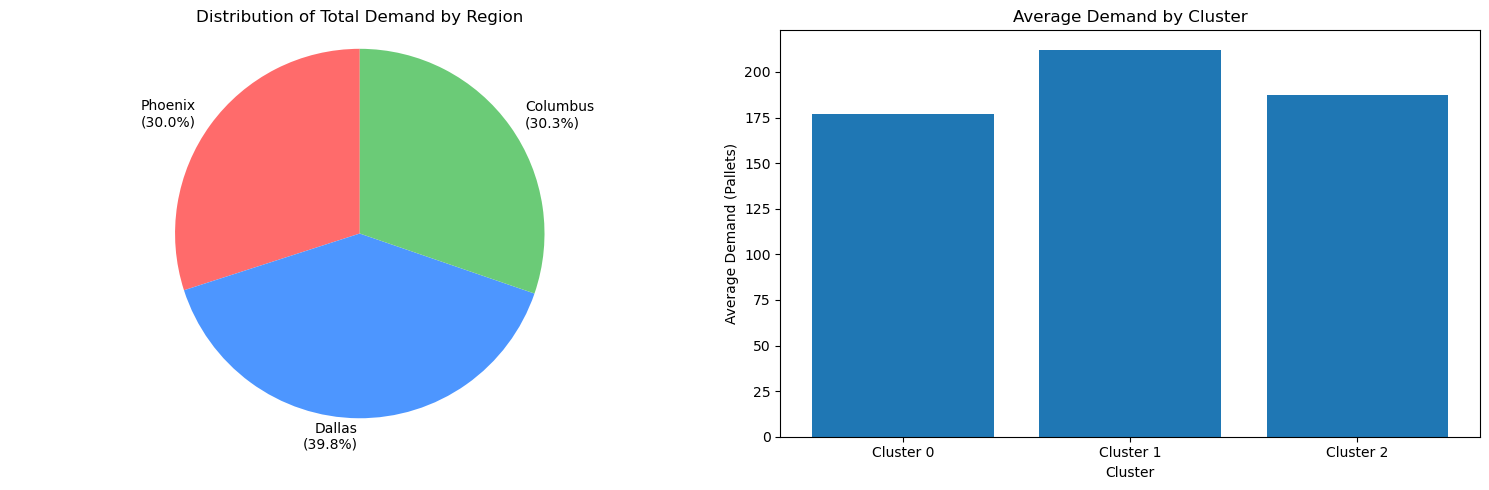

In [53]:
# Calculate demand statistics by cluster
cluster_stats = store_demand.groupby('Cluster').agg({
    'Demand_Pallets': ['sum', 'mean'],
    'StoreID': 'count'
}).round(2)

# Fix the column names
cluster_stats.columns = ['Total_Demand', 'Avg_Demand', 'Store_Count']
print("\nCluster Statistics:")
display(cluster_stats)

# Create demand distribution visualization
plt.figure(figsize=(15, 5))

# Pie chart of total demand by cluster
plt.subplot(1, 2, 1)
cluster_labels = ['Phoenix', 'Dallas', 'Columbus']  # Update labels to city names
demand_by_cluster = cluster_stats['Total_Demand']
demand_by_cluster = demand_by_cluster / demand_by_cluster.sum() * 100
plt.pie(demand_by_cluster, 
        labels=[f"{city}\n({pct:.1f}%)" for city, pct in zip(cluster_labels, demand_by_cluster)],
        colors=['#FF6B6B', '#4D96FF', '#6BCB77'],  # Match map colors
        autopct='',
        startangle=90)
plt.title('Distribution of Total Demand by Region')
plt.axis('equal')

# Bar chart of average demand by cluster
plt.subplot(1, 2, 2)
plt.bar(range(3), cluster_stats['Avg_Demand'])
plt.title('Average Demand by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Demand (Pallets)')
plt.xticks(range(3), [f'Cluster {i}' for i in range(3)])

plt.tight_layout()
plt.show()

# Distance Analysis


Average Distances (miles) by Cluster:


,Distance_to_Western,Distance_to_Central,Distance_to_Eastern
Cluster,,,
0,426.20,1256.83,1941.28
1,1815.29,1050.05,373.96
2,887.72,277.64,972.27


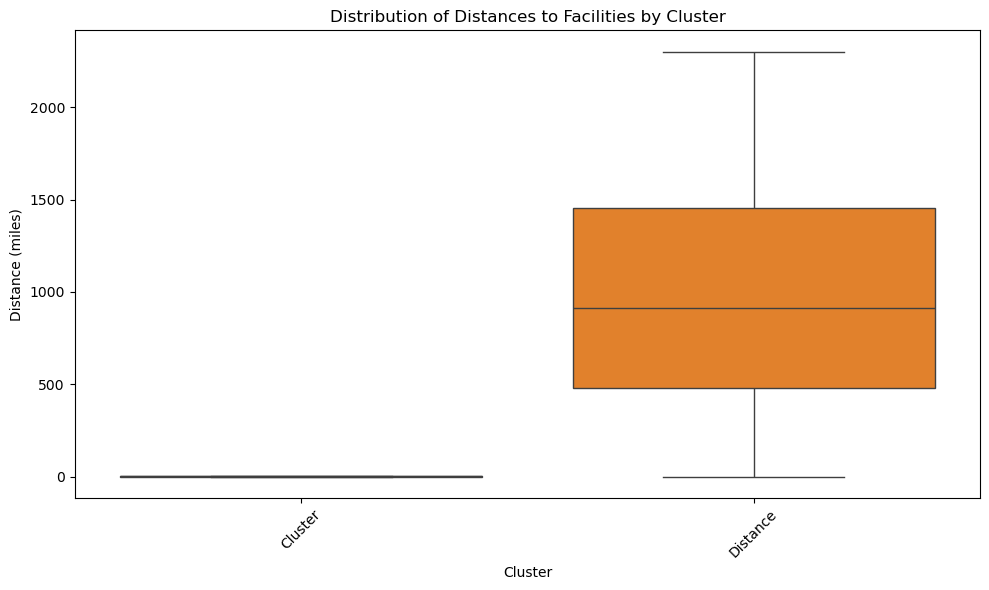

In [54]:
def calculate_distances_to_facilities():
    """Calculate distances from each store to each facility"""
    facility_locations = {}
    
    # Get facility coordinates
    for region, facility in selected_facilities.items():
        city = facility['Location'].split(',')[0].strip()
        state = facility['Location'].split(',')[1].strip()
        matching_stores = stores_df[
            (stores_df['City'] == city) & 
            (stores_df['State'] == state)
        ]
        if len(matching_stores) > 0:
            facility_locations[region] = (
                matching_stores.iloc[0]['Latitude'],
                matching_stores.iloc[0]['Longitude']
            )
    
    # Calculate distances
    distances = pd.DataFrame()
    for region, coords in facility_locations.items():
        distances[f'Distance_to_{region}'] = store_demand.apply(
            lambda row: geodesic(
                (row['Latitude'], row['Longitude']),
                coords
            ).miles,
            axis=1
        )
    
    return distances

distances_df = calculate_distances_to_facilities()
store_demand = pd.concat([store_demand, distances_df], axis=1)

# Calculate average distances by cluster
avg_distances = store_demand.groupby('Cluster')[
    ['Distance_to_Western', 'Distance_to_Central', 'Distance_to_Eastern']
].mean().round(2)

print("\nAverage Distances (miles) by Cluster:")
display(avg_distances)

# Create distance visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=store_demand.melt(
    id_vars=['Cluster'],
    value_vars=['Distance_to_Western', 'Distance_to_Central', 'Distance_to_Eastern'],
    var_name='Facility',
    value_name='Distance'
))
plt.title('Distribution of Distances to Facilities by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Distance (miles)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Facility Size and Cost Analysis

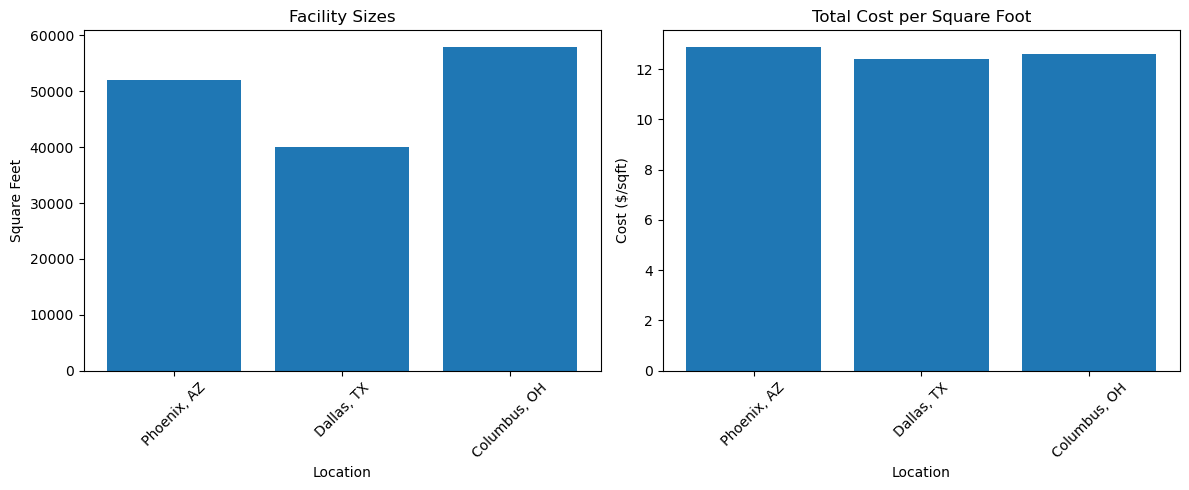

In [55]:
# Create facility comparison visualization
plt.figure(figsize=(12, 5))

# Size comparison
plt.subplot(1, 2, 1)
plt.bar(facility_costs['Location'], facility_costs['Size'])
plt.title('Facility Sizes')
plt.xlabel('Location')
plt.ylabel('Square Feet')
plt.xticks(rotation=45)

# Cost comparison
plt.subplot(1, 2, 2)
plt.bar(facility_costs['Location'], facility_costs['Total_Cost'])
plt.title('Total Cost per Square Foot')
plt.xlabel('Location')
plt.ylabel('Cost ($/sqft)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Key Findings

1. Facility Characteristics:
   - Columbus (Eastern): {selected_facilities['Eastern']['Size_SqFt']:,} sqft, ${selected_facilities['Eastern']['RentCost_SqFt'] + selected_facilities['Eastern']['UtilitiesOpsCost_SqFt']:.2f}/sqft
   - Dallas (Central): {selected_facilities['Central']['Size_SqFt']:,} sqft, ${selected_facilities['Central']['RentCost_SqFt'] + selected_facilities['Central']['UtilitiesOpsCost_SqFt']:.2f}/sqft
   - Phoenix (Western): {selected_facilities['Western']['Size_SqFt']:,} sqft, ${selected_facilities['Western']['RentCost_SqFt'] + selected_facilities['Western']['UtilitiesOpsCost_SqFt']:.2f}/sqft

2. Demand Distribution:
   - Western Cluster: {(cluster_stats.loc[0, 'Total_Demand'] / cluster_stats['Total_Demand'].sum() * 100):.1f}% of total demand
   - Central Cluster: {(cluster_stats.loc[1, 'Total_Demand'] / cluster_stats['Total_Demand'].sum() * 100):.1f}% of total demand
   - Eastern Cluster: {(cluster_stats.loc[2, 'Total_Demand'] / cluster_stats['Total_Demand'].sum() * 100):.1f}% of total demand

3. Average Distances:
   - Western Cluster average distance to Phoenix: {avg_distances.loc[0, 'Distance_to_Western']:,.0f} miles
   - Central Cluster average distance to Dallas: {avg_distances.loc[1, 'Distance_to_Central']:,.0f} miles
   - Eastern Cluster average distance to Columbus: {avg_distances.loc[2, 'Distance_to_Eastern']:,.0f} miles

4. Network Advantages:
   - Good geographic spread covering major US regions
   - Columbus and Phoenix provide large facility sizes (58k and 52k sqft)
   - Dallas offers central location with moderate cost per sqft
   - All facilities have good transportation infrastructure